# DinhDuc's Notbook About SER on EmoDB

### Import Packages

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
from tqdm import tqdm
import warnings
import wandb
import soundfile as sf
warnings.filterwarnings("ignore")


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import f1_score, confusion_matrix,classification_report
from sklearn.model_selection import train_test_split

In [2]:
# wandb.login()

### Loading Data

In [3]:
emo = "/kaggle/input/berlin-database-of-emotional-speech-emodb/wav/"
emo_directory_list = os.listdir(emo)

file_emotion = []
file_path = []
for dir in emo_directory_list:
    if dir.endswith(".wav"):
      label = dir.split(".")[0][-2]
      file_path.append(os.path.join(emo, dir))
      file_emotion.append(label)

# Create DataFrame
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
emo_df = pd.concat([emotion_df, path_df], axis=1)

# More Specific Label's Name
emo_df.replace({'Emotions': {'W':'angry', 'L':'boredom', 'E':'disgust', 'A':'fear', 'F':'happy', 'T' : 'sad', 'N' : 'neutral'}}, inplace=True)
emo_df.head(10)

,Emotions,Path
0,happy,/kaggle/input/berlin-database-of-emotional-spe...
1,happy,/kaggle/input/berlin-database-of-emotional-spe...
2,angry,/kaggle/input/berlin-database-of-emotional-spe...
3,angry,/kaggle/input/berlin-database-of-emotional-spe...
4,angry,/kaggle/input/berlin-database-of-emotional-spe...
5,fear,/kaggle/input/berlin-database-of-emotional-spe...
6,angry,/kaggle/input/berlin-database-of-emotional-spe...
7,sad,/kaggle/input/berlin-database-of-emotional-spe...
8,angry,/kaggle/input/berlin-database-of-emotional-spe...
9,angry,/kaggle/input/berlin-database-of-emotional-spe...


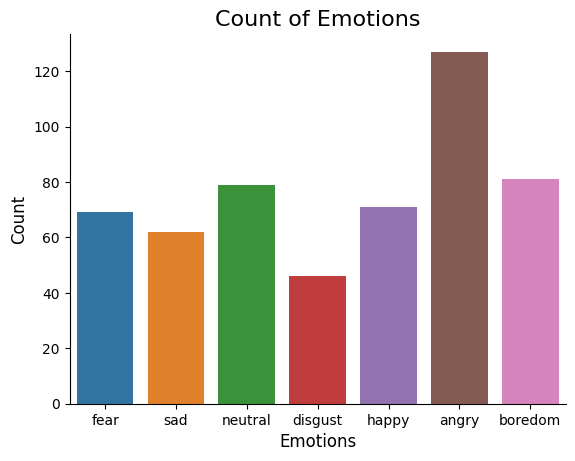

In [4]:
data_path = emo_df
data_path = data_path.sample(frac=1, random_state=42).reset_index(drop=True)
plt.title('Count of Emotions', size=16)
sns.countplot(data_path, x="Emotions")
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)

### Feature Extraction

In [5]:
def get_sound_data(path, target_sr=44100):
  """
  Input:
    - path: path to audio file
    - sr: target sample rate
  Output:
    - 1st element: sound data (array of waveform values), 1D if mono,
                   2D (frames x channels) if stero
    - 2nd element: sample rate (the current sample rate)
  """
  data, orig_sr = sf.read(path)
  data_resample = librosa.resample(data, orig_sr=orig_sr, target_sr=target_sr)

  # Get average if audio is muilti channels
  if len(data_resample.shape) > 1:
    data_resample = np.average(data_resample, axis=0)
  return data_resample, target_sr

  # End get_sound_data function

In [6]:
def windows(data, window_size):
  """
  Breake the sample into smaller, half overlaping and equal samples
  to satisfy the balanced in each sample's length.
  Input:
    - data: sound data
    - window_size: size of each smaller sample
  Yield:
    - start: start index of each sample
    - end: end index of each sample
  """
  start = 0
  while start + window_size < len(data):
    yield start, start + window_size
    start += (window_size // 2)

# End windows function

In [7]:
def extract_features(df, label_dict, bands=64, frames=64, hop_length=512, n_fft=1024, target_sr=44100):
  """
  Input:
    - frames: Number of frames in each window
    - n_fft: Length of each frame
    - hop_length: Distance from the start index of current frame to the next one
    - bands: Number of mel bands to generate
  Output:

  """
  # Declare features's variables
  window_size = hop_length * (frames - 1)
  log_specgrams_full = []
  log_specgrams_hp = []
  mfcc_specgrams = []
  class_labels = []


  for row in tqdm(df.itertuples()):
    if row.Path.endswith(".wav"):
      label = label_to_index[row.Emotions]
        
      # Get each feature
      data, sr = get_sound_data(row.Path, target_sr=target_sr)
      for start, end in windows(data, window_size):

        signal = data[start:end]

        # Add label
        class_labels.append(label)

        # Get mfcc feature
        mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=bands)
        mfcc_specgrams.append(mfcc)
        # mfcc's shape is (n_mfcc, n_frames)

  # Reshape 4D input (n_windows, n_bands, n_frames, n_features)
  mfcc_specgrams = np.asarray(mfcc_specgrams).reshape(len(mfcc_specgrams), bands, frames, 1)

  # Combined USED features into a feature map
  features = np.concatenate((mfcc_specgrams, np.zeros(np.shape(mfcc_specgrams)), np.zeros(np.shape(mfcc_specgrams))), axis=3)

  # Create the third feature map which is the delta (derivative) of the log-scaled mel-spectrogram - USED
  for i in range(features.shape[0]):
    features[i, :, :, 2] = librosa.feature.delta(features[i, :, :, 0])
    features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0], order=2)

  return np.array(features), np.array(class_labels)

# End extract_features function

In [8]:
label_to_index = {
    'fear': 0,
    'disgust': 1,
    'happy': 2,
    'angry': 3,
    'sad': 4,
    'neutral': 5,
    'boredom': 6
}

features, labels = extract_features(data_path, label_dict=label_to_index, bands=128, frames=128)
print(features.shape)
print(labels.shape)

535it [00:35, 15.23it/s]


(1234, 128, 128, 3)
(1234,)


### Training Model

Epoch 1/200 - Train loss: 1.7791, Train acc: 0.3461 - Val loss: 1.4447, Val acc: 0.4241, Val F1: 0.1899
Epoch 2/200 - Train loss: 1.5302, Train acc: 0.4483 - Val loss: 1.2590, Val acc: 0.5570, Val F1: 0.3289
Epoch 3/200 - Train loss: 1.4328, Train acc: 0.4742 - Val loss: 1.3050, Val acc: 0.5127, Val F1: 0.3175
Epoch 4/200 - Train loss: 1.3701, Train acc: 0.4899 - Val loss: 1.3384, Val acc: 0.4684, Val F1: 0.2809
Epoch 5/200 - Train loss: 1.3069, Train acc: 0.5135 - Val loss: 1.0125, Val acc: 0.6456, Val F1: 0.4748
Epoch 6/200 - Train loss: 1.2542, Train acc: 0.5225 - Val loss: 1.0627, Val acc: 0.5823, Val F1: 0.4426
Epoch 7/200 - Train loss: 1.2266, Train acc: 0.5191 - Val loss: 1.1161, Val acc: 0.5316, Val F1: 0.3843
Epoch 8/200 - Train loss: 1.1572, Train acc: 0.5629 - Val loss: 1.0864, Val acc: 0.5506, Val F1: 0.3666
Epoch 9/200 - Train loss: 1.1185, Train acc: 0.5831 - Val loss: 0.8409, Val acc: 0.6709, Val F1: 0.4956
Epoch 10/200 - Train loss: 1.0835, Train acc: 0.6090 - Val loss:

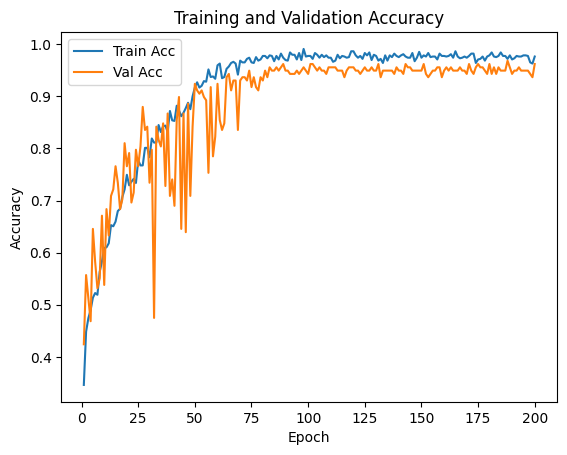

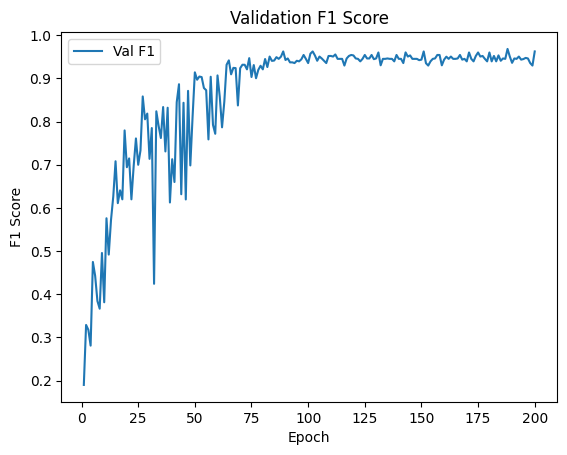

Evaluate on Test Set
Loading Best Model ...
Done


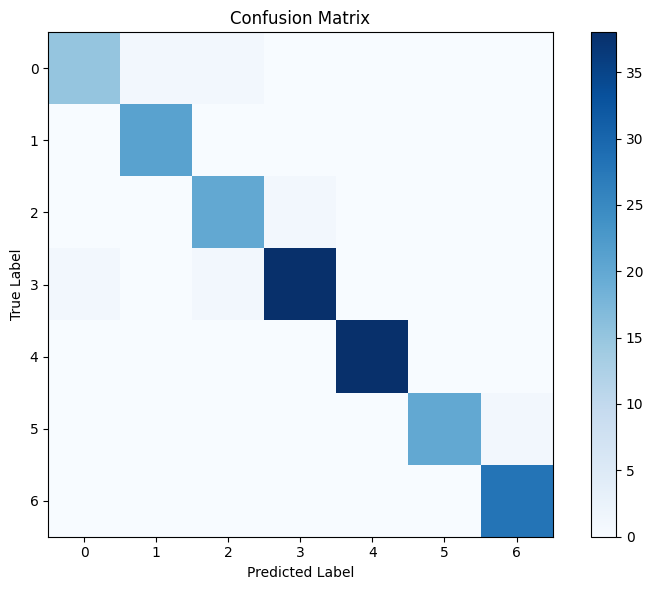

              precision    recall  f1-score   support

           0       0.94      0.88      0.91        17
           1       0.95      1.00      0.98        21
           2       0.91      0.95      0.93        21
           3       0.97      0.95      0.96        40
           4       1.00      1.00      1.00        38
           5       1.00      0.95      0.98        21
           6       0.97      1.00      0.98        28

    accuracy                           0.97       186
   macro avg       0.96      0.96      0.96       186
weighted avg       0.97      0.97      0.97       186



In [9]:
# ==== Configuration ====
BATCH_SIZE = 4
LR = 1e-4
EPOCHS = 200
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

features = features.astype(np.float32)
labels = labels.astype(np.int64).reshape(-1)

x_train_val, x_test, y_train_val, y_test = train_test_split(features, labels, random_state=42, stratify=labels, test_size=0.15)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, random_state=42, stratify=y_train_val, test_size=0.15)

class AudioDataset(Dataset):
    def __init__(self, data, targets=None):
        self.data = torch.from_numpy(data).permute(0, 3, 1, 2).float()
        self.targets = torch.from_numpy(targets)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        if self.targets is not None:
            y = self.targets[idx]
            return x, y
        else:
            return x
            
train_dataset = AudioDataset(x_train, y_train)
val_dataset = AudioDataset(x_val, y_val)
test_dataset = AudioDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


# ==== CNN Model ====
class AudioCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Dropout(0.4)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 7)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

model = AudioCNN().to(DEVICE)

# ==== Loss, Optimizer, Scheduler ====
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# ==== Training & Evaluation Functions ====
def train_epoch(loader):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)
    return running_loss / total, correct / total

def eval_epoch(loader, model_path=None):
    if model_path is not None:
        print('Loading Best Model ...')
        model.load_state_dict(torch.load(model_path))
        print('Done')
    model.eval()
    running_loss, all_preds, all_targets = 0.0, [], []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    acc = (np.array(all_preds) == np.array(all_targets)).mean()
    f1 = f1_score(all_targets, all_preds, average='macro')
    return running_loss / len(all_targets), acc, f1, all_preds, all_targets

# ==== Main Training Loop ====
best_val_acc = 0.0
best_val_f1 = 0.0
train_losses, val_losses = [], []
train_accs, val_accs, val_f1s = [], [], []

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_epoch(train_loader)
    val_loss, val_acc, val_f1, _, _ = eval_epoch(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch}/{EPOCHS}"
          f" - Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}"
          f" - Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

    scheduler.step(val_loss)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_audio_cnn_acc.pth')
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'best_audio_cnn_f1.pth')

print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Best Validation F1 Score: {best_val_f1:.4f}")

# ==== Plot Accuracy ====
plt.figure()
plt.plot(range(1, EPOCHS + 1), train_accs, label='Train Acc')
plt.plot(range(1, EPOCHS + 1), val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# ==== Plot F1 Score ====
plt.figure()
plt.plot(range(1, EPOCHS + 1), val_f1s, label='Val F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Validation F1 Score')
plt.legend()
plt.show()

# ==== Confusion Matrix ====
print("Evaluate on Test Set")
model_path = 'best_audio_cnn_f1.pth'
_, _, _, all_preds, all_targets = eval_epoch(test_loader, model_path)
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = [str(i) for i in range(cm.shape[0])]
plt.xticks(np.arange(len(classes)), classes)
plt.yticks(np.arange(len(classes)), classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# ==== Classification Report ====
print(classification_report(all_targets, all_preds))